# DATAHON BrainByte

## Membuat Dataset

### Langkah 1 : Persiapan Data Master

In [1]:
import pandas as pd
import numpy as np
import random

# Atur seed untuk hasil yang konsisten
random.seed(42)
np.random.seed(42)
# ==============================================================================
# LANGKAH 1: PERSIAPAN DATA MASTER (VERSI LENGKAP 38 PROVINSI)
# ==============================================================================
print("Mempersiapkan data master untuk 38 provinsi...")

# Daftar ibu kota berdasarkan grup wilayah/pulau utama
SUMATRA = ['Banda Aceh', 'Medan', 'Palembang', 'Padang', 'Bengkulu', 'Pekanbaru', 'Tanjung Pinang', 'Jambi', 'Bandar Lampung', 'Pangkal Pinang']
JAWA = ['Serang', 'Jakarta', 'Bandung', 'Semarang', 'Yogyakarta', 'Surabaya']
KALIMANTAN = ['Pontianak', 'Samarinda', 'Banjarbaru', 'Palangkaraya', 'Tanjung Selor']
BALI_NUSA_TENGGARA = ['Denpasar', 'Kupang', 'Mataram']
SULAWESI = ['Gorontalo', 'Mamuju', 'Palu', 'Manado', 'Kendari', 'Makassar']
MALUKU_PAPUA = ['Sofifi', 'Ambon', 'Manokwari', 'Jayapura', 'Nabire', 'Jayawijaya', 'Merauke', 'Sorong']

# Gabungkan semua kota menjadi satu daftar utama
KOTA_INDONESIA = SUMATRA + JAWA + KALIMANTAN + BALI_NUSA_TENGGARA + SULAWESI + MALUKU_PAPUA

# Data master lainnya
KURIR_INDONESIA = ['JNE', 'J&T', 'SiCepat', 'Anteraja']
JUMLAH_DATA = 20000 # Jumlah data dinaikkan untuk cakupan yang lebih baik

# Membaca dataset produk Olist untuk mendapatkan distribusi berat yang realistis
try:
    df_products = pd.read_csv('/content/olist_products_dataset.csv')
    realistic_weights = (df_products['product_weight_g'].dropna().sample(JUMLAH_DATA, replace=True) / 1000).round(2)
    print("Berhasil memuat dan mengambil sampel berat dari file olist_products_dataset.csv.")
except FileNotFoundError:
    print("File olist_products_dataset.csv tidak ditemukan. Menggunakan berat acak sebagai alternatif.")
    realistic_weights = np.round(np.random.uniform(0.1, 8.0, JUMLAH_DATA), 2)

# Membuat kerangka DataFrame awal
data = {
    'kota_asal': [random.choice(KOTA_INDONESIA) for _ in range(JUMLAH_DATA)],
    'kota_tujuan': [random.choice(KOTA_INDONESIA) for _ in range(JUMLAH_DATA)],
    'berat_kg': realistic_weights,
    'nama_kurir': [random.choice(KURIR_INDONESIA) for _ in range(JUMLAH_DATA)]
}
df = pd.DataFrame(data)
df = df[df['kota_asal'] != df['kota_tujuan']].reset_index(drop=True)
print(f"Membuat kerangka data awal dengan {len(df)} baris.")

Mempersiapkan data master untuk 38 provinsi...
File olist_products_dataset.csv tidak ditemukan. Menggunakan berat acak sebagai alternatif.
Membuat kerangka data awal dengan 19470 baris.


### Langkah 2: Implementasi Logika Bisnis

In [2]:
# ==============================================================================
# LANGKAH 2: IMPLEMENTASI LOGIKA BISNIS (VERSI LENGKAP)
# ==============================================================================
print("Menerapkan logika bisnis yang lebih detail (rute, kurir, dan noise)...")

# Fungsi pembantu untuk mendapatkan wilayah dari sebuah kota
def get_region(city):
    if city in SUMATRA: return 'Sumatra'
    if city in JAWA: return 'Jawa'
    if city in KALIMANTAN: return 'Kalimantan'
    if city in BALI_NUSA_TENGGARA: return 'BaliNusaTenggara'
    if city in SULAWESI: return 'Sulawesi'
    if city in MALUKU_PAPUA: return 'MalukuPapua'
    return 'Unknown'

# --- 2a. Logika Jarak dan Rute yang Diperbarui ---
def get_route_info_detailed(row):
    asal, tujuan = row['kota_asal'], row['kota_tujuan']
    region_asal = get_region(asal)
    region_tujuan = get_region(tujuan)

    # Baseline default
    cost_multiplier = 1.0
    duration_days = 2.0

    if region_asal == region_tujuan: # Intra-Region
        if region_asal == 'Jawa':
            cost_multiplier, duration_days = 1.0, 2.0 # Paling cepat & murah
        elif region_asal in ['Sumatra', 'BaliNusaTenggara']:
            cost_multiplier, duration_days = 1.2, 3.0
        else: # Kalimantan, Sulawesi, Maluku-Papua
            cost_multiplier, duration_days = 1.5, 4.0 # Lebih sulit medannya
    else: # Inter-Region
        # Rute-rute yang sangat jauh (misal: Sumatra ke Papua)
        if {region_asal, region_tujuan} in [{'Sumatra', 'MalukuPapua'}, {'Sumatra', 'Sulawesi'}, {'Kalimantan', 'MalukuPapua'}]:
            cost_multiplier, duration_days = 3.0, 7.0
        # Rute jauh lainnya
        elif {region_asal, region_tujuan} in [{'Jawa', 'MalukuPapua'}, {'Jawa', 'Sulawesi'}]:
            cost_multiplier, duration_days = 2.5, 6.0
        # Rute medium (tetangga)
        else:
            cost_multiplier, duration_days = 1.8, 4.0

    return pd.Series([cost_multiplier, duration_days])

df[['pengali_biaya', 'durasi_dasar_hari']] = df.apply(get_route_info_detailed, axis=1)

# --- 2b. Perhitungan Biaya dan Durasi Dasar ---
BIAYA_DASAR_PER_KG = 9500
df['biaya_prediksi'] = df['berat_kg'] * BIAYA_DASAR_PER_KG * df['pengali_biaya']
df['durasi_prediksi_hari'] = df['durasi_dasar_hari']

# --- 2c. Logika Performa Kurir (Tetap sama) ---
df.loc[df['nama_kurir'] == 'J&T', 'durasi_prediksi_hari'] -= 0.5
df.loc[df['nama_kurir'] == 'SiCepat', 'durasi_prediksi_hari'] -= 0.75
df.loc[df['nama_kurir'] == 'SiCepat', 'biaya_prediksi'] *= 1.10
df.loc[df['nama_kurir'] == 'Anteraja', 'biaya_prediksi'] *= 0.95

# --- 2d. Tambahkan Noise agar Realistis ---
noise_biaya = np.random.randint(-5000, 5000, size=len(df))
noise_durasi = np.random.uniform(-0.5, 1.5, size=len(df))
df['biaya_prediksi'] = (df['biaya_prediksi'] + noise_biaya).astype(int)
df['durasi_prediksi_hari'] = (df['durasi_prediksi_hari'] + noise_durasi).round(1)

# --- 2e. Finalisasi Data ---
df['biaya_prediksi'] = df['biaya_prediksi'].clip(lower=5000)
df['durasi_prediksi_hari'] = df['durasi_prediksi_hari'].clip(lower=1.0)

Menerapkan logika bisnis yang lebih detail (rute, kurir, dan noise)...


### Langkah 3 : Membuat Dataset Akhir

In [3]:
# ==============================================================================
# LANGKAH 3: MEMBUAT DATASET AKHIR
# ==============================================================================
final_columns = ['kota_asal', 'kota_tujuan', 'berat_kg', 'nama_kurir', 'biaya_prediksi', 'durasi_prediksi_hari']
dataset_final_indonesia = df[final_columns]

nama_file_output = 'dataset_logistik_indonesia_38prov.csv'
dataset_final_indonesia.to_csv(nama_file_output, index=False)

print("\nProses selesai!")
print(f"Dataset sintetis Indonesia (38 Provinsi) telah berhasil dibuat dan disimpan sebagai '{nama_file_output}'.")
print("\nBerikut adalah 5 baris pertama dari dataset Anda:")
print(dataset_final_indonesia.head())


Proses selesai!
Dataset sintetis Indonesia (38 Provinsi) telah berhasil dibuat dan disimpan sebagai 'dataset_logistik_indonesia_38prov.csv'.

Berikut adalah 5 baris pertama dari dataset Anda:
    kota_asal kota_tujuan  berat_kg nama_kurir  biaya_prediksi  \
0       Jambi   Samarinda      3.06        J&T           47583   
1       Medan      Sofifi      7.61        JNE          211929   
2   Samarinda       Jambi      5.88        J&T          104008   
3    Surabaya        Palu      4.83   Anteraja          105310   
4  Yogyakarta   Pekanbaru      1.33        JNE           18414   

   durasi_prediksi_hari  
0                   4.1  
1                   6.5  
2                   4.9  
3                   6.0  
4                   4.9  


## EDA

### Load Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# --- 1. MUAT DATASET ---
try:
    # Ganti 'dataset_logistik_indonesia.csv' jika nama file Anda berbeda
    nama_file = '/content/dataset_logistik_indonesia_38prov.csv'
    df = pd.read_csv(nama_file)
    print(f"Dataset '{nama_file}' berhasil dimuat. Jumlah baris: {len(df)}")
except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan. Pastikan file tersebut ada di folder yang sama dengan skrip ini.")
    exit()

Dataset '/content/dataset_logistik_indonesia_38prov.csv' berhasil dimuat. Jumlah baris: 19470


### Statistik Deskriptif

In [ ]:
print("\nInformasi Dasar Dataset:")
df.info()

print("\nStatistik Deskriptif untuk Kolom Numerik:")
print(df.describe())


Informasi Dasar Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19470 entries, 0 to 19469
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kota_asal             19470 non-null  object 
 1   kota_tujuan           19470 non-null  object 
 2   berat_kg              19470 non-null  float64
 3   nama_kurir            19470 non-null  object 
 4   biaya_prediksi        19470 non-null  int64  
 5   durasi_prediksi_hari  19470 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 912.8+ KB

Statistik Deskriptif untuk Kolom Numerik:
           berat_kg  biaya_prediksi  durasi_prediksi_hari
count  19470.000000    19470.000000          19470.000000
mean       2.288596    47051.633898              5.094910
std        4.309772    92775.935992              1.602841
min        0.000000     5000.000000              1.000000
25%        0.300000     6329.750000              3.800000
50%

### Bar Chart Biaya Pengiriman Kurir


Membuat visualisasi data...


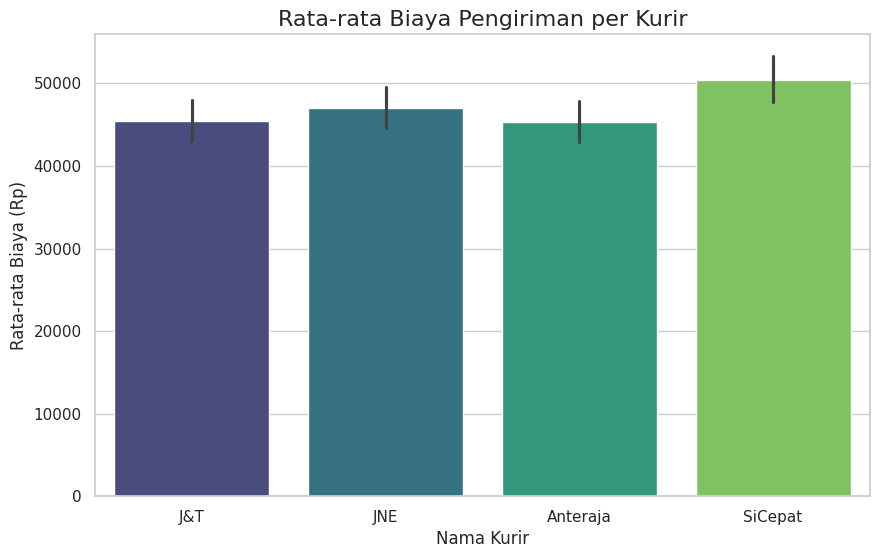

In [ ]:
print("\nMembuat visualisasi data...")

# A. Perbandingan Rata-rata Biaya per Kurir
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='nama_kurir', y='biaya_prediksi', palette='viridis')
plt.title('Rata-rata Biaya Pengiriman per Kurir', fontsize=16)
plt.xlabel('Nama Kurir', fontsize=12)
plt.ylabel('Rata-rata Biaya (Rp)', fontsize=12)
plt.show()

### Boxplot Durasi Pengiriman Kurir

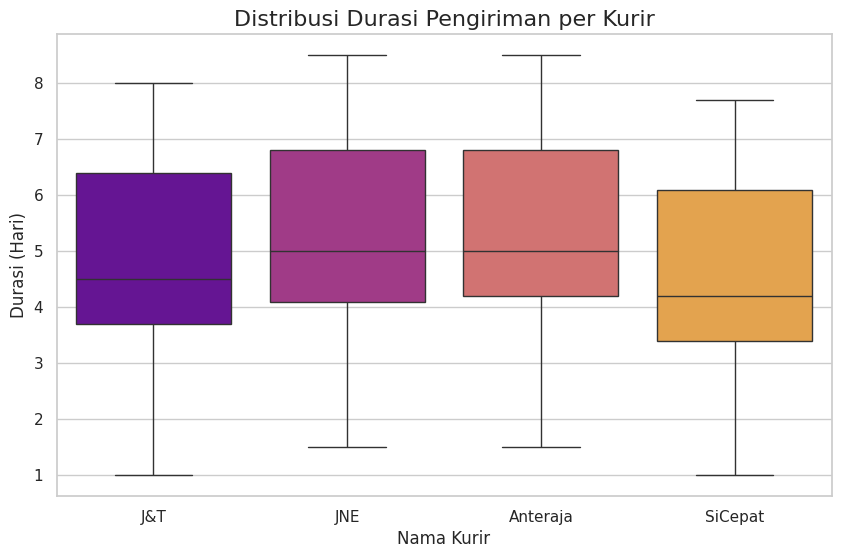

In [ ]:
# B. Distribusi Durasi Pengiriman per Kurir
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='nama_kurir', y='durasi_prediksi_hari', palette='plasma')
plt.title('Distribusi Durasi Pengiriman per Kurir', fontsize=16)
plt.xlabel('Nama Kurir', fontsize=12)
plt.ylabel('Durasi (Hari)', fontsize=12)
plt.show()

### Scatter Plot Berat dan Biaya

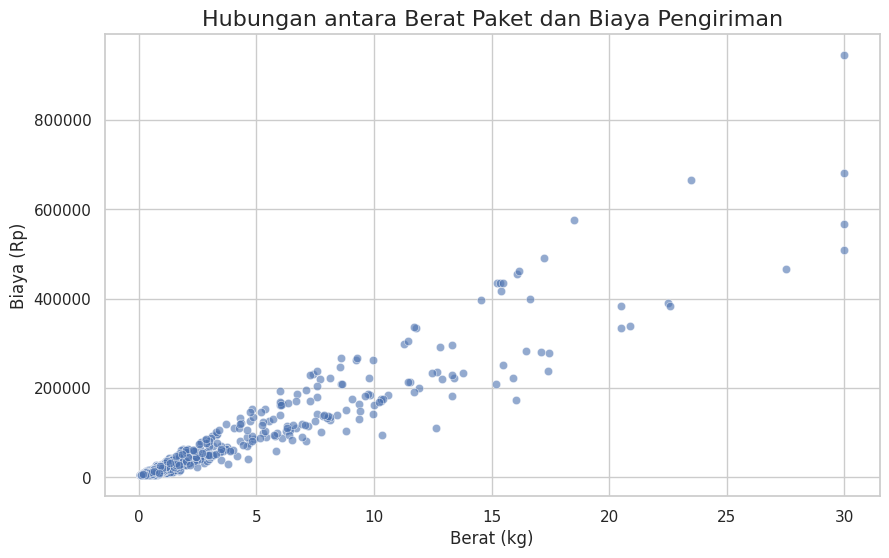

In [ ]:
# C. Hubungan antara Berat dan Biaya
plt.figure(figsize=(10, 6))
# Ambil sampel 1000 data agar plot tidak terlalu padat
sns.scatterplot(data=df.sample(1000), x='berat_kg', y='biaya_prediksi', alpha=0.6)
plt.title('Hubungan antara Berat Paket dan Biaya Pengiriman', fontsize=16)
plt.xlabel('Berat (kg)', fontsize=12)
plt.ylabel('Biaya (Rp)', fontsize=12)
plt.show()


### Correlation Matrix Durasi Pengiriman Antar Kota

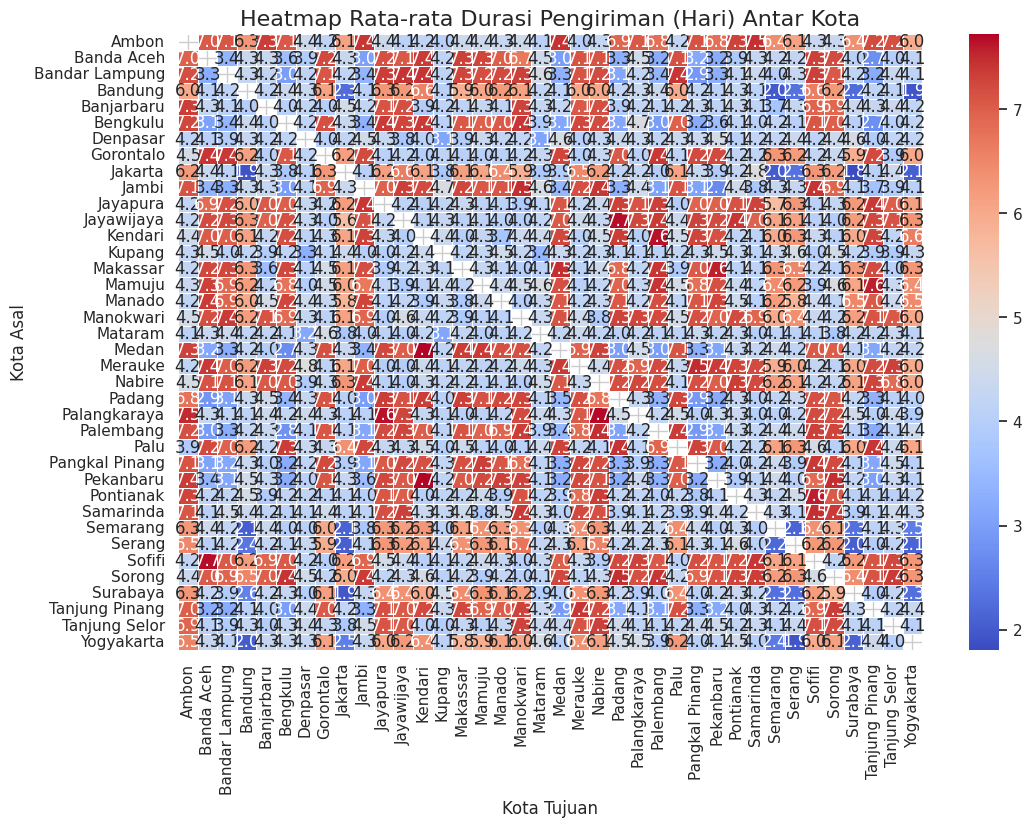

In [ ]:
# D. Heatmap Rata-rata Durasi Pengiriman Antar Kota
# Membuat pivot table untuk heatmap
heatmap_data = df.pivot_table(
    values='durasi_prediksi_hari',
    index='kota_asal',
    columns='kota_tujuan'
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5)
plt.title('Heatmap Rata-rata Durasi Pengiriman (Hari) Antar Kota', fontsize=16)
plt.xlabel('Kota Tujuan', fontsize=12)
plt.ylabel('Kota Asal', fontsize=12)
plt.show()

## Preprocessing Data

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1. MUAT DATASET ---
try:
    nama_file = '/content/dataset_logistik_indonesia_38prov.csv'
    df = pd.read_csv(nama_file)
    print(f"Dataset '{nama_file}' berhasil dimuat.")
except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan.")
    exit()

Dataset '/content/dataset_logistik_indonesia_38prov.csv' berhasil dimuat.


In [5]:
# --- 2. UBAH DATA KATEGORIKAL MENJADI ANGKA (ONE-HOT ENCODING) ---
# One-Hot Encoding akan membuat kolom baru untuk setiap nilai unik di kolom kategorikal.
# Contoh: kolom 'nama_kurir' akan diubah menjadi 'nama_kurir_JNE', 'nama_kurir_J&T', dst.
print("Melakukan One-Hot Encoding pada kolom kategorikal...")
df_encoded = pd.get_dummies(df, columns=['kota_asal', 'kota_tujuan', 'nama_kurir'], drop_first=True)

# Tampilkan beberapa baris pertama dari data yang sudah di-encode
print("Contoh data setelah di-encode:")
print(df_encoded.head())

Melakukan One-Hot Encoding pada kolom kategorikal...
Contoh data setelah di-encode:
   berat_kg  biaya_prediksi  durasi_prediksi_hari  kota_asal_Banda Aceh  \
0      3.06           47583                   4.1                 False   
1      7.61          211929                   6.5                 False   
2      5.88          104008                   4.9                 False   
3      4.83          105310                   6.0                 False   
4      1.33           18414                   4.9                 False   

   kota_asal_Bandar Lampung  kota_asal_Bandung  kota_asal_Banjarbaru  \
0                     False              False                 False   
1                     False              False                 False   
2                     False              False                 False   
3                     False              False                 False   
4                     False              False                 False   

   kota_asal_Bengkulu  kota_asal

In [6]:
# --- 3. PISAHKAN FITUR (X) DAN TARGET (y) ---
# Definisikan target prediksi
targets = ['biaya_prediksi', 'durasi_prediksi_hari']

# X adalah semua kolom KECUALI kolom target
X = df_encoded.drop(columns=targets)

# y adalah HANYA kolom target
y = df_encoded[targets]

print(f"\nFitur (X) berhasil dipisahkan dengan {X.shape[1]} kolom.")
print(f"Target (y) berhasil dipisahkan dengan {y.shape[1]} kolom.")


Fitur (X) berhasil dipisahkan dengan 78 kolom.
Target (y) berhasil dipisahkan dengan 2 kolom.


In [7]:
# --- 4. BAGI DATA MENJADI DATA LATIH DAN DATA UJI ---
# Membagi data dengan porsi 80% untuk latih dan 20% untuk uji.
# random_state=42 digunakan agar hasil pembagian data selalu sama setiap kali kode dijalankan.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("\nData berhasil dibagi menjadi set latih dan set uji.")
print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test:", X_test.shape)
print("Ukuran y_train:", y_train.shape)
print("Ukuran y_test:", y_test.shape)


Data berhasil dibagi menjadi set latih dan set uji.
Ukuran X_train: (15576, 78)
Ukuran X_test: (3894, 78)
Ukuran y_train: (15576, 2)
Ukuran y_test: (3894, 2)


## Train Model

In [8]:
# Impor library yang diperlukan
import pandas as pd
import lightgbm as lgb  # <- Mengimpor LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

In [9]:
# --- LANGKAH 1 & 2: MEMUAT DAN MEMPERSIAPKAN DATA (Sama seperti sebelumnya) ---
print("Memuat dan mempersiapkan data...")
try:
    # Pastikan path file ini benar
    nama_file = '/content/dataset_logistik_indonesia_38prov.csv'
    df = pd.read_csv(nama_file)
except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan.")
    print("Pastikan Anda sudah mengunggah atau membuat file dataset tersebut.")
    exit()

# One-Hot Encoding untuk fitur kategorikal
df_encoded = pd.get_dummies(df, columns=['kota_asal', 'kota_tujuan', 'nama_kurir'], drop_first=True)

# Memisahkan Fitur (X) dan Target (y)
targets = ['biaya_prediksi', 'durasi_prediksi_hari']
X = df_encoded.drop(columns=targets)
y = df_encoded[targets]

# Membagi data menjadi set latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
print("Data berhasil dimuat dan dipersiapkan.")

Memuat dan mempersiapkan data...
Data berhasil dimuat dan dipersiapkan.


### Train Model LightGBM

In [11]:
# ==============================================================================
# LANGKAH 3: PELATIHAN MODEL DENGAN LIGHTGBM
# ==============================================================================
print("\nMemulai proses pelatihan model dengan LightGBM...")

# 3a. Latih Model untuk Prediksi BIAYA
print("Melatih model LightGBM untuk prediksi biaya...")
# Membuat instance model LightGBM Regressor
# Catatan: LightGBM tidak memiliki 'objective' seperti XGBoost, fungsinya ditentukan secara default untuk regresi.
# Hyperparameter learning_rate dan n_estimators bisa disamakan untuk perbandingan.
model_biaya_lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
# Melatih model dengan data latih
model_biaya_lgbm.fit(X_train, y_train['biaya_prediksi'])
print("✅ Model LightGBM untuk BIAYA berhasil dilatih.")


# 3b. Latih Model untuk Prediksi DURASI
print("\nMelatih model LightGBM untuk prediksi durasi...")
# Membuat instance model LightGBM Regressor
model_durasi_lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
# Melatih model dengan data latih
model_durasi_lgbm.fit(X_train, y_train['durasi_prediksi_hari'])
print("✅ Model LightGBM untuk DURASI berhasil dilatih.")

print("\nProses pelatihan kedua model LightGBM telah selesai.")

from joblib import dump
dump(model_biaya_lgbm, 'lgbm_regressor_biaya_awal.joblib')
dump(model_durasi_lgbm, 'lgbm_regressor_durasi_awal.joblib')
print("\nProses Penyimpanan model selesai")


Memulai proses pelatihan model dengan LightGBM...
Melatih model LightGBM untuk prediksi biaya...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 15576, number of used features: 78
[LightGBM] [Info] Start training from score 82816.225989
✅ Model LightGBM untuk BIAYA berhasil dilatih.

Melatih model LightGBM untuk prediksi durasi...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 15576, number of used features: 78
[LightGBM] [I

## Implementasi Fungsi

In [12]:
# ==============================================================================
# REKAP VARIABEL GLOBAL (Dibutuhkan untuk fungsi rekomendasi)
# Pastikan variabel-variabel ini sudah terdefinisi dari langkah sebelumnya.
# ==============================================================================
# Fitur yang digunakan saat pelatihan model
MODEL_FEATURES = X_train.columns

# Daftar kota dan kurir untuk validasi input
SUMATRA = ['Banda Aceh', 'Medan', 'Palembang', 'Padang', 'Bengkulu', 'Pekanbaru', 'Tanjung Pinang', 'Jambi', 'Bandar Lampung', 'Pangkal Pinang']
JAWA = ['Serang', 'Jakarta', 'Bandung', 'Semarang', 'Yogyakarta', 'Surabaya']
KALIMANTAN = ['Pontianak', 'Samarinda', 'Banjarbaru', 'Palangkaraya', 'Tanjung Selor']
BALI_NUSA_TENGGARA = ['Denpasar', 'Kupang', 'Mataram']
SULAWESI = ['Gorontalo', 'Mamuju', 'Palu', 'Manado', 'Kendari', 'Makassar']
MALUKU_PAPUA = ['Sofifi', 'Ambon', 'Manokwari', 'Jayapura', 'Nabire', 'Jayawijaya', 'Merauke', 'Sorong']
KOTA_INDONESIA = SUMATRA + JAWA + KALIMANTAN + BALI_NUSA_TENGGARA + SULAWESI + MALUKU_PAPUA
KURIR_INDONESIA = ['JNE', 'J&T', 'SiCepat', 'Anteraja']


# ==============================================================================
# FUNGSI REKOMENDASI IMPLEMENTASI (VERSI LIGHTGBM)
# ==============================================================================

def rekomendasi_kurir_lgbm(kota_asal, kota_tujuan, berat_kg, prioritas='terbaik'):
    """
    Fungsi untuk memberikan rekomendasi kurir menggunakan model LightGBM.
    Prioritas bisa berupa: 'terbaik' (seimbang), 'termurah', 'tercepat'.
    """
    print(f"\n===== Mencari Rekomendasi (LGBM) untuk: {kota_asal} -> {kota_tujuan} ({berat_kg} kg) | Prioritas: {prioritas} =====")

    if kota_asal not in KOTA_INDONESIA or kota_tujuan not in KOTA_INDONESIA:
        return "Error: Nama kota asal atau tujuan tidak valid."

    hasil = []

    for kurir in KURIR_INDONESIA:
        # Siapkan data input sesuai format yang dipelajari model
        input_data = pd.DataFrame(columns=MODEL_FEATURES)
        input_data.loc[0] = 0
        input_data['berat_kg'] = berat_kg

        # Set kolom one-hot encoding yang sesuai
        asal_col = f'kota_asal_{kota_asal}'
        tujuan_col = f'kota_tujuan_{kota_tujuan}'
        kurir_col = f'nama_kurir_{kurir}'

        if asal_col in input_data.columns: input_data[asal_col] = 1
        if tujuan_col in input_data.columns: input_data[tujuan_col] = 1
        if kurir_col in input_data.columns: input_data[kurir_col] = 1

        # Lakukan Prediksi menggunakan model LightGBM
        pred_biaya = model_biaya_lgbm.predict(input_data)[0]
        pred_durasi = model_durasi_lgbm.predict(input_data)[0]

        hasil.append({
            'Kurir': kurir,
            'Estimasi Biaya (Rp)': int(pred_biaya),
            'Estimasi Durasi (Hari)': round(pred_durasi, 1)
        })

    # Hitung Skor & Ranking berdasarkan Prioritas
    df_hasil = pd.DataFrame(hasil)

    if prioritas == 'termurah':
        df_hasil = df_hasil.sort_values(by='Estimasi Biaya (Rp)')
    elif prioritas == 'tercepat':
        df_hasil = df_hasil.sort_values(by='Estimasi Durasi (Hari)')
    else: # 'terbaik'
        # Normalisasi untuk skoring (membuat nilai antara 0 dan 1)
        min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0
        df_hasil['norm_biaya'] = df_hasil[['Estimasi Biaya (Rp)']].apply(min_max_scaler)
        df_hasil['norm_durasi'] = df_hasil[['Estimasi Durasi (Hari)']].apply(min_max_scaler)
        # Skor adalah gabungan dari normalisasi biaya dan durasi (nilai lebih rendah lebih baik)
        df_hasil['skor'] = 0.5 * df_hasil['norm_biaya'] + 0.5 * df_hasil['norm_durasi']
        df_hasil = df_hasil.sort_values(by='skor')

    return df_hasil[['Kurir', 'Estimasi Biaya (Rp)', 'Estimasi Durasi (Hari)']].reset_index(drop=True)


# --- CONTOH PENGGUNAAN FUNGSI REKOMENDASI (VERSI LIGHTGBM) ---
# 1. Mencari opsi seimbang untuk rute antar pulau yang ramai
rekomendasi_1 = rekomendasi_kurir_lgbm('Jakarta', 'Medan', 2.5, prioritas='terbaik')
print(rekomendasi_1)

# 2. Mencari opsi paling cepat untuk rute jauh
rekomendasi_2 = rekomendasi_kurir_lgbm('Bandung', 'Jayapura', 1.0, prioritas='tercepat')
print(rekomendasi_2)

# 3. Mencari opsi paling murah untuk rute dalam pulau
rekomendasi_3 = rekomendasi_kurir_lgbm('Yogyakarta', 'Surabaya', 0.8, prioritas='termurah')
print(rekomendasi_3)


===== Mencari Rekomendasi (LGBM) untuk: Jakarta -> Medan (2.5 kg) | Prioritas: terbaik =====
      Kurir  Estimasi Biaya (Rp)  Estimasi Durasi (Hari)
0       J&T                45604                     4.2
1  Anteraja                44003                     4.6
2   SiCepat                49224                     4.0
3       JNE                45315                     4.8

===== Mencari Rekomendasi (LGBM) untuk: Bandung -> Jayapura (1.0 kg) | Prioritas: tercepat =====
      Kurir  Estimasi Biaya (Rp)  Estimasi Durasi (Hari)
0   SiCepat                26100                     5.4
1       J&T                25033                     5.7
2       JNE                24919                     6.3
3  Anteraja                24059                     6.3

===== Mencari Rekomendasi (LGBM) untuk: Yogyakarta -> Surabaya (0.8 kg) | Prioritas: termurah =====
      Kurir  Estimasi Biaya (Rp)  Estimasi Durasi (Hari)
0  Anteraja                 9913                     4.0
1       JNE            

## Evaluasi Model

### Mean Absolute Error

In [15]:
# ==============================================================================
# LANGKAH 4: EVALUASI MODEL LIGHTGBM
# ==============================================================================
print("\nMemulai proses evaluasi model LightGBM pada data uji...")

# 4a. Evaluasi Model Biaya LightGBM
print("\n--- Hasil Evaluasi Model Biaya (LightGBM) ---")
# Membuat prediksi pada data uji
prediksi_biaya_lgbm = model_biaya_lgbm.predict(X_test)
# Menghitung MAE (Mean Absolute Error)
mae_biaya_lgbm = mean_absolute_error(y_test['biaya_prediksi'], prediksi_biaya_lgbm)
# Menampilkan hasil
print(f"Mean Absolute Error (MAE) untuk Biaya: Rp {mae_biaya_lgbm:,.2f}")

# 4b. Evaluasi Model Durasi LightGBM
print("\n--- Hasil Evaluasi Model Durasi (LightGBM) ---")
# Membuat prediksi pada data uji
prediksi_durasi_lgbm = model_durasi_lgbm.predict(X_test)
# Menghitung MAE
mae_durasi_lgbm = mean_absolute_error(y_test['durasi_prediksi_hari'], prediksi_durasi_lgbm)
# Menampilkan hasil
print(f"Mean Absolute Error (MAE) untuk Durasi: {mae_durasi_lgbm:.2f} hari")


Memulai proses evaluasi model LightGBM pada data uji...

--- Hasil Evaluasi Model Biaya (LightGBM) ---
Mean Absolute Error (MAE) untuk Biaya: Rp 14,974.94

--- Hasil Evaluasi Model Durasi (LightGBM) ---
Mean Absolute Error (MAE) untuk Durasi: 0.89 hari


## Feature Engineering


In [16]:
import pandas as pd
import numpy as np

In [17]:
# ==============================================================================
# 1. MEMUAT DATASET
# ==============================================================================
print("Memuat dataset 38 provinsi...")
try:
    nama_file = '/content/dataset_logistik_indonesia_38prov.csv'
    df = pd.read_csv(nama_file)
    print(f"Dataset '{nama_file}' berhasil dimuat dengan {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan.")
    exit()

Memuat dataset 38 provinsi...
Dataset '/content/dataset_logistik_indonesia_38prov.csv' berhasil dimuat dengan 19470 baris.


### Fitur 1

In [18]:
# ==============================================================================
# 2. MEMBUAT FITUR BARU: 'kategori_jarak'
# ==============================================================================
print("\nMembuat fitur 'kategori_jarak'...")

# Data master wilayah (diperlukan untuk logika)
SUMATRA = ['Banda Aceh', 'Medan', 'Palembang', 'Padang', 'Bengkulu', 'Pekanbaru', 'Tanjung Pinang', 'Jambi', 'Bandar Lampung', 'Pangkal Pinang']
JAWA = ['Serang', 'Jakarta', 'Bandung', 'Semarang', 'Yogyakarta', 'Surabaya']
KALIMANTAN = ['Pontianak', 'Samarinda', 'Banjarbaru', 'Palangkaraya', 'Tanjung Selor']
BALI_NUSA_TENGGARA = ['Denpasar', 'Kupang', 'Mataram']
SULAWESI = ['Gorontalo', 'Mamuju', 'Palu', 'Manado', 'Kendari', 'Makassar']
MALUKU_PAPUA = ['Sofifi', 'Ambon', 'Manokwari', 'Jayapura', 'Nabire', 'Jayawijaya', 'Merauke', 'Sorong']

# Fungsi pembantu untuk mendapatkan wilayah dari sebuah kota
def get_region(city):
    if city in SUMATRA: return 'Sumatra'
    if city in JAWA: return 'Jawa'
    if city in KALIMANTAN: return 'Kalimantan'
    if city in BALI_NUSA_TENGGARA: return 'BaliNusaTenggara'
    if city in SULAWESI: return 'Sulawesi'
    if city in MALUKU_PAPUA: return 'MalukuPapua'
    return 'Unknown'

# Fungsi untuk membuat kategori jarak
def get_kategori_jarak(row):
    region_asal = get_region(row['kota_asal'])
    region_tujuan = get_region(row['kota_tujuan'])

    if region_asal == region_tujuan:
        return 'Dalam Wilayah'
    elif {region_asal, region_tujuan} <= {'Jawa', 'Sumatra', 'BaliNusaTenggara'}:
        return 'Antar Pulau Dekat'
    else:
        return 'Antar Pulau Jauh'

# Terapkan fungsi ke dataframe untuk membuat kolom baru
df['kategori_jarak'] = df.apply(get_kategori_jarak, axis=1)

print("Fitur 'kategori_jarak' berhasil dibuat.")
print("Distribusi Kategori Jarak:")
print(df['kategori_jarak'].value_counts())



Membuat fitur 'kategori_jarak'...
Fitur 'kategori_jarak' berhasil dibuat.
Distribusi Kategori Jarak:
kategori_jarak
Antar Pulau Jauh     13320
Dalam Wilayah         3165
Antar Pulau Dekat     2985
Name: count, dtype: int64


### Fitur 2

In [19]:
# ==============================================================================
# 3. MEMBUAT FITUR BARU: 'interaksi_kurir_rute'
# ==============================================================================
print("\nMembuat fitur 'interaksi_kurir_rute'...")

# Gabungkan nama kurir dengan kategori jarak
df['interaksi_kurir_rute'] = df['nama_kurir'] + '_' + df['kategori_jarak'].str.replace(' ', '_')

print("Fitur 'interaksi_kurir_rute' berhasil dibuat.")


Membuat fitur 'interaksi_kurir_rute'...
Fitur 'interaksi_kurir_rute' berhasil dibuat.


### Save Dataset

In [20]:
# ==============================================================================
# 4. SIMPAN DATASET BARU
# ==============================================================================
# Tampilkan 5 baris pertama dari dataset baru yang sudah memiliki fitur tambahan
print("\nContoh dataset dengan fitur baru:")
print(df.head())

# Simpan ke file CSV baru
nama_file_baru = 'dataset_logistik_featured.csv'
df.to_csv(nama_file_baru, index=False)
print(f"\nDataset baru dengan fitur tambahan telah disimpan sebagai '{nama_file_baru}'.")


Contoh dataset dengan fitur baru:
    kota_asal kota_tujuan  berat_kg nama_kurir  biaya_prediksi  \
0       Jambi   Samarinda      3.06        J&T           47583   
1       Medan      Sofifi      7.61        JNE          211929   
2   Samarinda       Jambi      5.88        J&T          104008   
3    Surabaya        Palu      4.83   Anteraja          105310   
4  Yogyakarta   Pekanbaru      1.33        JNE           18414   

   durasi_prediksi_hari     kategori_jarak       interaksi_kurir_rute  
0                   4.1   Antar Pulau Jauh       J&T_Antar_Pulau_Jauh  
1                   6.5   Antar Pulau Jauh       JNE_Antar_Pulau_Jauh  
2                   4.9   Antar Pulau Jauh       J&T_Antar_Pulau_Jauh  
3                   6.0   Antar Pulau Jauh  Anteraja_Antar_Pulau_Jauh  
4                   4.9  Antar Pulau Dekat      JNE_Antar_Pulau_Dekat  

Dataset baru dengan fitur tambahan telah disimpan sebagai 'dataset_logistik_featured.csv'.


## Prepro

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split

print("Memuat dataset baru dengan fitur tambahan...")
try:
    # Muat dataset baru yang sudah memiliki fitur tambahan
    nama_file = '/content/dataset_logistik_featured.csv'
    df = pd.read_csv(nama_file)
    print(f"Dataset '{nama_file}' berhasil dimuat.")
except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan.")
    exit()

Memuat dataset baru dengan fitur tambahan...
Dataset '/content/dataset_logistik_featured.csv' berhasil dimuat.


In [28]:
# --- Definisikan SEMUA kolom kategorikal ---
kolom_kategorikal = [
    'kota_asal',
    'kota_tujuan',
    'nama_kurir',
    'kategori_jarak',
    'interaksi_kurir_rute'  # <-- PASTIKAN INI DI-INCLUDE
]

print("Melakukan One-Hot Encoding pada semua kolom kategorikal...")
df_encoded = pd.get_dummies(df, columns=kolom_kategorikal, drop_first=True)


Melakukan One-Hot Encoding pada semua kolom kategorikal...


In [29]:
# --- Pisahkan Fitur (X) dan Target (y) ---
targets = ['biaya_prediksi', 'durasi_prediksi_hari']
X = df_encoded.drop(columns=targets)
y = df_encoded[targets]

# --- Bagi Data Menjadi Data Latih dan Data Uji ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("\nData berhasil dipersiapkan untuk model dan siap untuk dilatih.")
print("Ukuran X_train setelah encoding baru:", X_train.shape)


Data berhasil dipersiapkan untuk model dan siap untuk dilatih.
Ukuran X_train setelah encoding baru: (15576, 91)


## Train Model

In [30]:
# Impor library yang diperlukan
import pandas as pd
import lightgbm as lgb  # <- Mengimpor LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

In [31]:
# --- LANGKAH 1 & 2: MEMUAT DAN MEMPERSIAPKAN DATA (Sama seperti sebelumnya) ---
print("Memuat dan mempersiapkan data...")
try:
    # Pastikan path file ini benar
    nama_file = '/content/dataset_logistik_featured.csv'
    df = pd.read_csv(nama_file)
except FileNotFoundError:
    print(f"Error: File '{nama_file}' tidak ditemukan.")
    print("Pastikan Anda sudah mengunggah atau membuat file dataset tersebut.")
    exit()

# --- BAGIAN YANG DIPERBAIKI ---
# Definisikan SEMUA kolom kategorikal untuk di-encode
kolom_kategorikal = [
    'kota_asal',
    'kota_tujuan',
    'nama_kurir',
    'kategori_jarak',
    'interaksi_kurir_rute'
]
print("Melakukan One-Hot Encoding pada semua kolom kategorikal...")
df_encoded = pd.get_dummies(df, columns=kolom_kategorikal, drop_first=True)
# -----------------------------

# Memisahkan Fitur (X) dan Target (y)
targets = ['biaya_prediksi', 'durasi_prediksi_hari']
X = df_encoded.drop(columns=targets)
y = df_encoded[targets]

# Membagi data menjadi set latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
print("Data berhasil dimuat dan dipersiapkan.")

Memuat dan mempersiapkan data...
Melakukan One-Hot Encoding pada semua kolom kategorikal...
Data berhasil dimuat dan dipersiapkan.


In [32]:
# ==============================================================================
# LANGKAH 3: PELATIHAN MODEL DENGAN LIGHTGBM
# ==============================================================================
print("\nMemulai proses pelatihan model dengan LightGBM...")

# 3a. Latih Model untuk Prediksi BIAYA
print("Melatih model LightGBM untuk prediksi biaya...")
# Membuat instance model LightGBM Regressor
# Catatan: LightGBM tidak memiliki 'objective' seperti XGBoost, fungsinya ditentukan secara default untuk regresi.
# Hyperparameter learning_rate dan n_estimators bisa disamakan untuk perbandingan.
model_biaya_lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
# Melatih model dengan data latih
model_biaya_lgbm.fit(X_train, y_train['biaya_prediksi'])
print("✅ Model LightGBM untuk BIAYA berhasil dilatih.")


# 3b. Latih Model untuk Prediksi DURASI
print("\nMelatih model LightGBM untuk prediksi durasi...")
# Membuat instance model LightGBM Regressor
model_durasi_lgbm = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
# Melatih model dengan data latih
model_durasi_lgbm.fit(X_train, y_train['durasi_prediksi_hari'])
print("✅ Model LightGBM untuk DURASI berhasil dilatih.")

print("\nProses pelatihan kedua model LightGBM telah selesai.")

from joblib import dump
dump(model_biaya_lgbm, 'lgbm_regressor_biaya_feature_eng.joblib')
dump(model_durasi_lgbm, 'lgbm_regressor_durasi_feature_eng.joblib')
print("\nProses Penyimpanan model selesai")


Memulai proses pelatihan model dengan LightGBM...
Melatih model LightGBM untuk prediksi biaya...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 15576, number of used features: 91
[LightGBM] [Info] Start training from score 82816.225989
✅ Model LightGBM untuk BIAYA berhasil dilatih.

Melatih model LightGBM untuk prediksi durasi...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

## Implemetasi Model


In [33]:
# ==============================================================================
# REKAP VARIABEL GLOBAL (Dibutuhkan untuk fungsi rekomendasi)
# Pastikan variabel-variabel ini sudah terdefinisi dari langkah sebelumnya.
# ==============================================================================
# Fitur yang digunakan saat pelatihan model
MODEL_FEATURES = X_train.columns

# Daftar kota dan kurir untuk validasi input
SUMATRA = ['Banda Aceh', 'Medan', 'Palembang', 'Padang', 'Bengkulu', 'Pekanbaru', 'Tanjung Pinang', 'Jambi', 'Bandar Lampung', 'Pangkal Pinang']
JAWA = ['Serang', 'Jakarta', 'Bandung', 'Semarang', 'Yogyakarta', 'Surabaya']
KALIMANTAN = ['Pontianak', 'Samarinda', 'Banjarbaru', 'Palangkaraya', 'Tanjung Selor']
BALI_NUSA_TENGGARA = ['Denpasar', 'Kupang', 'Mataram']
SULAWESI = ['Gorontalo', 'Mamuju', 'Palu', 'Manado', 'Kendari', 'Makassar']
MALUKU_PAPUA = ['Sofifi', 'Ambon', 'Manokwari', 'Jayapura', 'Nabire', 'Jayawijaya', 'Merauke', 'Sorong']
KOTA_INDONESIA = SUMATRA + JAWA + KALIMANTAN + BALI_NUSA_TENGGARA + SULAWESI + MALUKU_PAPUA
KURIR_INDONESIA = ['JNE', 'J&T', 'SiCepat', 'Anteraja']


# ==============================================================================
# FUNGSI REKOMENDASI IMPLEMENTASI (VERSI LIGHTGBM)
# ==============================================================================

def rekomendasi_kurir_lgbm(kota_asal, kota_tujuan, berat_kg, prioritas='terbaik'):
    """
    Fungsi untuk memberikan rekomendasi kurir menggunakan model LightGBM.
    Prioritas bisa berupa: 'terbaik' (seimbang), 'termurah', 'tercepat'.
    """
    print(f"\n===== Mencari Rekomendasi (LGBM) untuk: {kota_asal} -> {kota_tujuan} ({berat_kg} kg) | Prioritas: {prioritas} =====")

    if kota_asal not in KOTA_INDONESIA or kota_tujuan not in KOTA_INDONESIA:
        return "Error: Nama kota asal atau tujuan tidak valid."

    hasil = []

    for kurir in KURIR_INDONESIA:
        # Siapkan data input sesuai format yang dipelajari model
        input_data = pd.DataFrame(columns=MODEL_FEATURES)
        input_data.loc[0] = 0
        input_data['berat_kg'] = berat_kg

        # Set kolom one-hot encoding yang sesuai
        asal_col = f'kota_asal_{kota_asal}'
        tujuan_col = f'kota_tujuan_{kota_tujuan}'
        kurir_col = f'nama_kurir_{kurir}'

        if asal_col in input_data.columns: input_data[asal_col] = 1
        if tujuan_col in input_data.columns: input_data[tujuan_col] = 1
        if kurir_col in input_data.columns: input_data[kurir_col] = 1

        # Lakukan Prediksi menggunakan model LightGBM
        pred_biaya = model_biaya_lgbm.predict(input_data)[0]
        pred_durasi = model_durasi_lgbm.predict(input_data)[0]

        hasil.append({
            'Kurir': kurir,
            'Estimasi Biaya (Rp)': int(pred_biaya),
            'Estimasi Durasi (Hari)': round(pred_durasi, 1)
        })

    # Hitung Skor & Ranking berdasarkan Prioritas
    df_hasil = pd.DataFrame(hasil)

    if prioritas == 'termurah':
        df_hasil = df_hasil.sort_values(by='Estimasi Biaya (Rp)')
    elif prioritas == 'tercepat':
        df_hasil = df_hasil.sort_values(by='Estimasi Durasi (Hari)')
    else: # 'terbaik'
        # Normalisasi untuk skoring (membuat nilai antara 0 dan 1)
        min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0
        df_hasil['norm_biaya'] = df_hasil[['Estimasi Biaya (Rp)']].apply(min_max_scaler)
        df_hasil['norm_durasi'] = df_hasil[['Estimasi Durasi (Hari)']].apply(min_max_scaler)
        # Skor adalah gabungan dari normalisasi biaya dan durasi (nilai lebih rendah lebih baik)
        df_hasil['skor'] = 0.5 * df_hasil['norm_biaya'] + 0.5 * df_hasil['norm_durasi']
        df_hasil = df_hasil.sort_values(by='skor')

    return df_hasil[['Kurir', 'Estimasi Biaya (Rp)', 'Estimasi Durasi (Hari)']].reset_index(drop=True)


# --- CONTOH PENGGUNAAN FUNGSI REKOMENDASI (VERSI LIGHTGBM) ---
# 1. Mencari opsi seimbang untuk rute antar pulau yang ramai
rekomendasi_1 = rekomendasi_kurir_lgbm('Jakarta', 'Medan', 2.5, prioritas='terbaik')
print(rekomendasi_1)

# 2. Mencari opsi paling cepat untuk rute jauh
rekomendasi_2 = rekomendasi_kurir_lgbm('Bandung', 'Jayapura', 1.0, prioritas='tercepat')
print(rekomendasi_2)

# 3. Mencari opsi paling murah untuk rute dalam pulau
rekomendasi_3 = rekomendasi_kurir_lgbm('Yogyakarta', 'Surabaya', 0.8, prioritas='termurah')
print(rekomendasi_3)


===== Mencari Rekomendasi (LGBM) untuk: Jakarta -> Medan (2.5 kg) | Prioritas: terbaik =====
      Kurir  Estimasi Biaya (Rp)  Estimasi Durasi (Hari)
0       J&T                44316                     4.1
1   SiCepat                47351                     3.8
2  Anteraja                43877                     4.4
3       JNE                43981                     4.4

===== Mencari Rekomendasi (LGBM) untuk: Bandung -> Jayapura (1.0 kg) | Prioritas: tercepat =====
      Kurir  Estimasi Biaya (Rp)  Estimasi Durasi (Hari)
0   SiCepat                22964                     3.8
1       J&T                21483                     4.1
2       JNE                21312                     4.5
3  Anteraja                21209                     4.5

===== Mencari Rekomendasi (LGBM) untuk: Yogyakarta -> Surabaya (0.8 kg) | Prioritas: termurah =====
      Kurir  Estimasi Biaya (Rp)  Estimasi Durasi (Hari)
0  Anteraja                13492                     4.4
1       JNE            

## Evaluasi Model

In [34]:
# ==============================================================================
# LANGKAH 4: EVALUASI MODEL LIGHTGBM
# ==============================================================================
print("\nMemulai proses evaluasi model LightGBM pada data uji...")

# 4a. Evaluasi Model Biaya LightGBM
print("\n--- Hasil Evaluasi Model Biaya (LightGBM) ---")
# Membuat prediksi pada data uji
prediksi_biaya_lgbm = model_biaya_lgbm.predict(X_test)
# Menghitung MAE (Mean Absolute Error)
mae_biaya_lgbm = mean_absolute_error(y_test['biaya_prediksi'], prediksi_biaya_lgbm)
# Menampilkan hasil
print(f"Mean Absolute Error (MAE) untuk Biaya: Rp {mae_biaya_lgbm:,.2f}")

# 4b. Evaluasi Model Durasi LightGBM
print("\n--- Hasil Evaluasi Model Durasi (LightGBM) ---")
# Membuat prediksi pada data uji
prediksi_durasi_lgbm = model_durasi_lgbm.predict(X_test)
# Menghitung MAE
mae_durasi_lgbm = mean_absolute_error(y_test['durasi_prediksi_hari'], prediksi_durasi_lgbm)
# Menampilkan hasil
print(f"Mean Absolute Error (MAE) untuk Durasi: {mae_durasi_lgbm:.2f} hari")


Memulai proses evaluasi model LightGBM pada data uji...

--- Hasil Evaluasi Model Biaya (LightGBM) ---
Mean Absolute Error (MAE) untuk Biaya: Rp 8,518.22

--- Hasil Evaluasi Model Durasi (LightGBM) ---
Mean Absolute Error (MAE) untuk Durasi: 0.68 hari


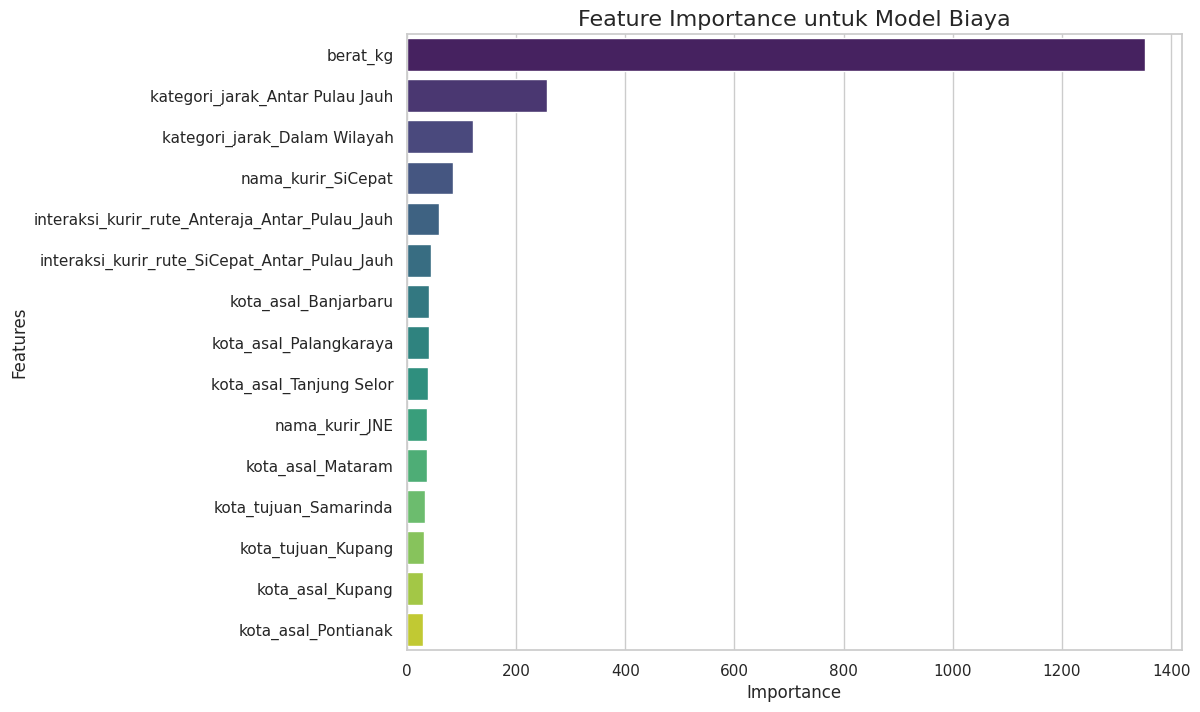

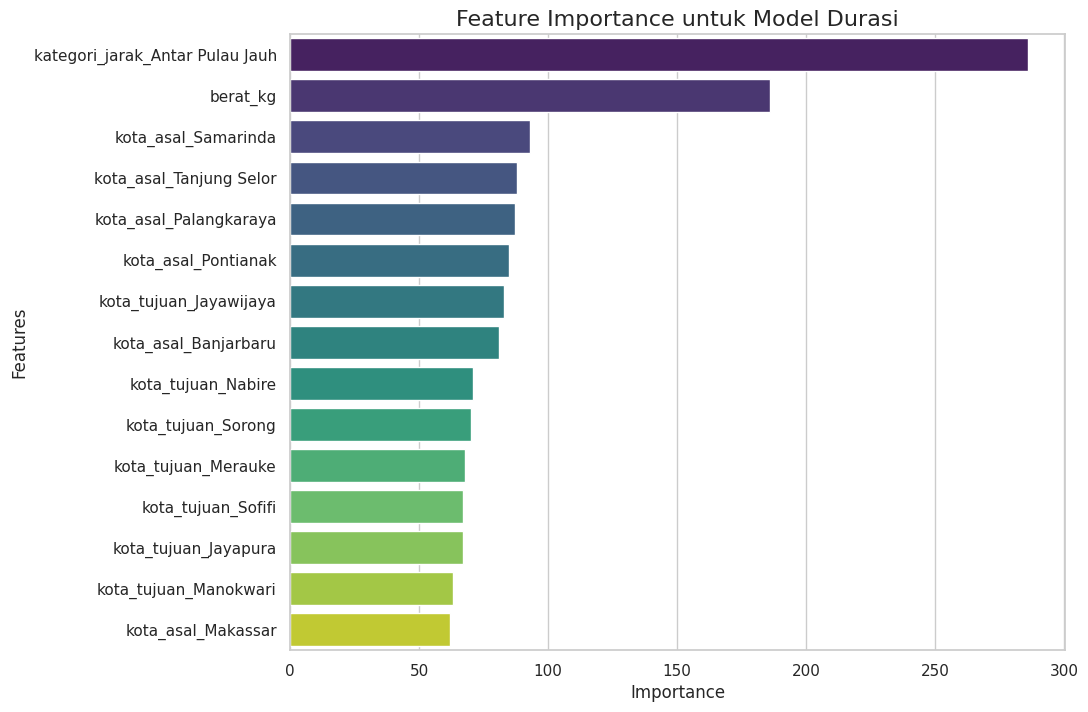

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_importance(importance, names, model_type):
    """Fungsi untuk membuat plot feature importance."""
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Ambil 15 fitur teratas
    top_features = fi_df.head(15)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features['feature_importance'], y=top_features['feature_names'], palette='viridis')
    plt.title(f'Feature Importance untuk Model {model_type}', fontsize=16)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# Asumsikan model_biaya_lgbm, model_durasi_lgbm, dan X_train sudah ada dari kode sebelumnya
# Tampilkan feature importance untuk model biaya
plot_feature_importance(model_biaya_lgbm.feature_importances_, X_train.columns, 'Biaya')

# Tampilkan feature importance untuk model durasi
plot_feature_importance(model_durasi_lgbm.feature_importances_, X_train.columns, 'Durasi')

In [ ]:
# Buat salinan dari X_test untuk analisis
df_analisis = X_test.copy()

# Tambahkan nilai prediksi dan nilai aktual ke dataframe
df_analisis['biaya_aktual'] = y_test['biaya_prediksi']
df_analisis['biaya_prediksi_model'] = model_biaya_lgbm.predict(X_test)
df_analisis['durasi_aktual'] = y_test['durasi_prediksi_hari']
df_analisis['durasi_prediksi_model'] = model_durasi_lgbm.predict(X_test)

# Hitung selisih absolut (error)
df_analisis['error_biaya'] = abs(df_analisis['biaya_aktual'] - df_analisis['biaya_prediksi_model'])
df_analisis['error_durasi'] = abs(df_analisis['durasi_aktual'] - df_analisis['durasi_prediksi_model'])

# Tampilkan 5 kesalahan terbesar untuk biaya
print("--- 5 Kesalahan Prediksi Biaya Terbesar ---")
print(df_analisis.sort_values('error_biaya', ascending=False).head())

# Tampilkan 5 kesalahan terbesar untuk durasi
print("\n--- 5 Kesalahan Prediksi Durasi Terbesar ---")
print(df_analisis.sort_values('error_durasi', ascending=False).head())

--- 5 Kesalahan Prediksi Biaya Terbesar ---
       berat_kg  kota_asal_Banda Aceh  kota_asal_Bandar Lampung  \
4941       29.7                 False                     False   
933        30.0                 False                     False   
47         30.0                 False                     False   
2814       30.0                 False                     False   
15118      30.0                 False                     False   

       kota_asal_Bandung  kota_asal_Banjarbaru  kota_asal_Bengkulu  \
4941               False                 False               False   
933                False                 False               False   
47                 False                 False               False   
2814               False                 False               False   
15118              False                 False               False   

       kota_asal_Denpasar  kota_asal_Gorontalo  kota_asal_Jakarta  \
4941                False                False              Fal

## Stacking

In [35]:
# prompt: stackingregressor using default RF, catboost, xgboost, lightbgm, LR, DTregressor, apapun itu lah pokoknya

!pip install catboost
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

# ==============================================================================
# STACKING REGRESSOR UNTUK PREDIKSI BIAYA DAN DURASI
# ==============================================================================

print("\nMemulai proses pelatihan Stacking Regressor...")

# Definisikan base model (regressor)
# Menggunakan parameter default untuk contoh ini
estimators_biaya = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('dt', DecisionTreeRegressor(random_state=42))
]

estimators_durasi = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('lgbm', lgb.LGBMRegressor(random_state=42)),
    ('dt', DecisionTreeRegressor(random_state=42))
]

# Definisikan meta-model (final estimator)
# Menggunakan Linear Regression as meta-model
meta_regressor = LinearRegression()

# 1. Stacking Regressor for Biaya Prediction
print("Melatih Stacking Regressor untuk prediksi biaya...")
stack_regressor_biaya = StackingRegressor(
    estimators=estimators_biaya,
    final_estimator=meta_regressor,
    cv=5  # Number of folds for cross-validation
)
stack_regressor_biaya.fit(X_train, y_train['biaya_prediksi'])
print("✅ Stacking Regressor untuk BIAYA berhasil dilatih.")

# 2. Stacking Regressor for Durasi Prediction
print("\nMelatih Stacking Regressor untuk prediksi durasi...")
stack_regressor_durasi = StackingRegressor(
    estimators=estimators_durasi,
    final_estimator=meta_regressor,
    cv=5 # Number of folds for cross-validation
)
stack_regressor_durasi.fit(X_train, y_train['durasi_prediksi_hari'])
print("✅ Stacking Regressor untuk DURASI berhasil dilatih.")

print("\nProses pelatihan kedua Stacking Regressor telah selesai.")

from joblib import dump
dump(stack_regressor_biaya, 'stack_regressor_biaya_feature_eng.joblib')
dump(stack_regressor_durasi, 'stack_regressor_durasi_feature_eng.joblib')
print("\nProses Penyimpanan model selesai")

# --- Implementasi Fungsi Rekomendasi dengan Stacking Regressor ---

def rekomendasi_kurir_stacking(kota_asal, kota_tujuan, berat_kg, prioritas='terbaik'):
    """
    Fungsi untuk memberikan rekomendasi kurir menggunakan model Stacking Regressor (VERSI PERBAIKAN).
    """
    print(f"\n===== [Stacking] Rekomendasi untuk: {kota_asal} -> {kota_tujuan} ({berat_kg} kg) | Prioritas: {prioritas} =====")

    if kota_asal not in KOTA_INDONESIA or kota_tujuan not in KOTA_INDONESIA:
        return "Error: Nama kota asal atau tujuan tidak valid."

    hasil = []

    # Dapatkan kategori jarak sekali saja
    kategori_jarak = get_kategori_jarak({'kota_asal': kota_asal, 'kota_tujuan': kota_tujuan})

    for kurir in KURIR_INDONESIA:
        # 1. Siapkan data input dengan semua fitur model diisi nol
        input_data = pd.DataFrame(columns=MODEL_FEATURES) # MODEL_FEATURES dari saat training
        input_data.loc[0] = 0

        # 2. Isi nilai yang diketahui
        input_data['berat_kg'] = berat_kg

        # 3. Set kolom one-hot encoding yang relevan menjadi 1
        # --- PERBAIKAN DI BAGIAN INI ---
        asal_col = f'kota_asal_{kota_asal}'
        if asal_col in input_data.columns:
            input_data[asal_col] = 1

        tujuan_col = f'kota_tujuan_{kota_tujuan}'
        if tujuan_col in input_data.columns:
            input_data[tujuan_col] = 1

        kurir_col = f'nama_kurir_{kurir}'
        if kurir_col in input_data.columns:
            input_data[kurir_col] = 1

        kategori_jarak_col = f"kategori_jarak_{kategori_jarak.replace(' ', '_')}"
        if kategori_jarak_col in input_data.columns:
            input_data[kategori_jarak_col] = 1

        interaksi_col = f"interaksi_kurir_rute_{kurir}_{kategori_jarak.replace(' ', '_')}"
        if interaksi_col in input_data.columns:
            input_data[interaksi_col] = 1
        # --- AKHIR PERBAIKAN ---

        # 4. Lakukan Prediksi
        pred_biaya = stack_regressor_biaya.predict(input_data)[0]
        pred_durasi = stack_regressor_durasi.predict(input_data)[0]

        hasil.append({
            'Kurir': kurir,
            'Estimasi Biaya (Rp)': int(pred_biaya),
            'Estimasi Durasi (Hari)': round(pred_durasi, 1)
        })

    # Logika sorting tetap sama
    df_hasil = pd.DataFrame(hasil)
    if prioritas == 'termurah':
        df_hasil = df_hasil.sort_values(by='Estimasi Biaya (Rp)')
    elif prioritas == 'tercepat':
        df_hasil = df_hasil.sort_values(by='Estimasi Durasi (Hari)')
    else: # 'terbaik'
        min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0
        df_hasil['norm_biaya'] = df_hasil[['Estimasi Biaya (Rp)']].apply(min_max_scaler)
        df_hasil['norm_durasi'] = df_hasil[['Estimasi Durasi (Hari)']].apply(min_max_scaler)
        df_hasil['skor'] = 0.5 * df_hasil['norm_biaya'] + 0.5 * df_hasil['norm_durasi']
        df_hasil = df_hasil.sort_values(by='skor')

    return df_hasil[['Kurir', 'Estimasi Biaya (Rp)', 'Estimasi Durasi (Hari)']].reset_index(drop=True)

# --- Contoh Penggunaan Fungsi Rekomendasi dengan Stacking Regressor ---
# 1. Mencari opsi seimbang
rekomendasi_stack_1 = rekomendasi_kurir_stacking('Jakarta', 'Medan', 2.5, prioritas='terbaik')
print(rekomendasi_stack_1)

# 2. Mencari opsi paling cepat
rekomendasi_stack_2 = rekomendasi_kurir_stacking('Bandung', 'Jayapura', 1.0, prioritas='tercepat')
print(rekomendasi_stack_2)

# 3. Mencari opsi paling murah
rekomendasi_stack_3 = rekomendasi_kurir_stacking('Yogyakarta', 'Surabaya', 0.8, prioritas='termurah')
print(rekomendasi_stack_3)

# ==============================================================================
# EVALUASI MODEL STACKING REGRESSOR
# ==============================================================================
print("\nMemulai proses evaluasi Stacking Regressor pada data uji...")

# 1. Evaluasi Stacking Regressor untuk Biaya
print("\n--- Hasil Evaluasi Stacking Regressor (Biaya) ---")
prediksi_biaya_stacking = stack_regressor_biaya.predict(X_test)
mae_biaya_stacking = mean_absolute_error(y_test['biaya_prediksi'], prediksi_biaya_stacking)
print(f"Mean Absolute Error (MAE) untuk Biaya (Stacking): Rp {mae_biaya_stacking:,.2f}")

# 2. Evaluasi Stacking Regressor untuk Durasi
print("\n--- Hasil Evaluasi Stacking Regressor (Durasi) ---")
prediksi_durasi_stacking = stack_regressor_durasi.predict(X_test)
mae_durasi_stacking = mean_absolute_error(y_test['durasi_prediksi_hari'], prediksi_durasi_stacking)
print(f"Mean Absolute Error (MAE) untuk Durasi (Stacking): {mae_durasi_stacking:.2f} hari")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00

Memulai proses pelatihan Stacking Regressor...
Melatih Stacking Regressor untuk prediksi biaya...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 15576, number of used features: 91
[LightGBM] [Info] Start training from score 82816.225989
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 1